In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import nltk
import pickle

In [0]:
import pickle
infile = open('/content/drive/My Drive/Emotion-Detection/tokenizer.pickle','rb')
tokenizer = pickle.load(infile)
infile.close()

In [4]:
df = pd.read_csv('/content/drive/My Drive/Emotion-Detection/dataset_final_preprocessed.csv')
df.head(10)

,Text,Emotion
0,tempt first name one mani project archdioces u...,Happy
1,would love see facebook live everi monday fri...,Happy
2,heartbreak brokenheart 1,Sad
3,perfect moment quot bananaquot success life mo...,Happy
4,damn effin scare furiou could imagin everyon e...,Fear
5,think right live safe healthi happi happi life...,Happy
6,april 12th worri,Fear
7,not even gonna get song brokenheart,Sad
8,oh brokenheart cryingfac brokenheart cr...,Sad
9,ill admit feel nostalg see photo sweet littl g...,Happy


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

import os
import sys
from pathlib import Path

sequences = [str(text).split() for text in df['Text'].values]
tokenized = tokenizer.texts_to_sequences(sequences)
pad_data = pad_sequences(tokenized,100)

encoder = LabelBinarizer()
encoder.fit(df['Emotion'].unique())

label = encoder.transform(df['Emotion'].values)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(pad_data,label, test_size=0.20, random_state=42)

In [0]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

In [0]:
input_dim = len(tokenizer.word_index) + 1
num_classes = len(df['Emotion'].unique())
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [8]:
print(input_dim,num_classes,input_length)

109391 7 100


In [0]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

# output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_weights_path = Path('/content/drive/My Drive/Emotion-Detection/lstm_with_drop_model_weights.h5').resolve()
model.load_weights(model_weights_path.as_posix())

In [0]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

Normalized confusion matrix


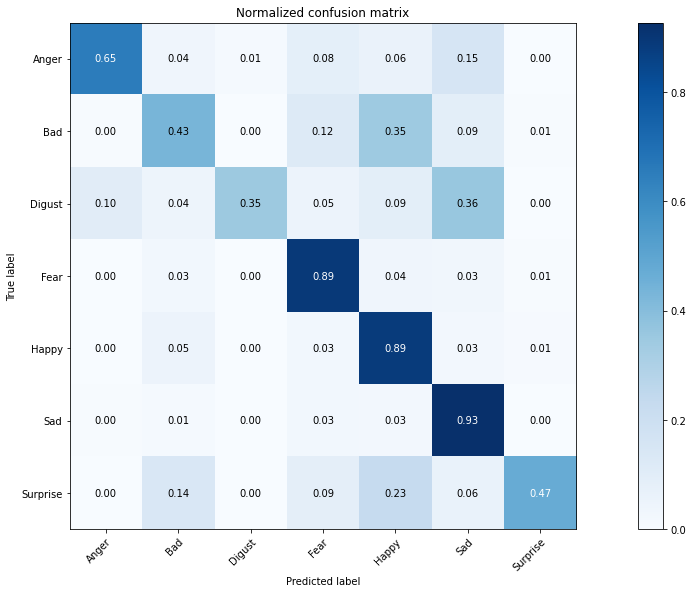

In [14]:
fig, ax = plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)
fig.set_size_inches(18.5, 10.5)
fig.savefig('/content/drive/My Drive/Emotion-Detection/eval_matrix.png')
